In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, json, itertools

from tqdm import tqdm
from sklearn import *
from copy import deepcopy
from scipy.stats.stats import pearsonr, spearmanr
from shapely.geometry import Polygon
from collections import Counter

import sys
sys.path.insert(0, '../correlation') 

from modules import correlation, evaluation, query, residual, visualization

sns.set(color_codes=True)

data_dir = os.path.join('..','..','data')

/home/poom/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/home/poom/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/home/poom/.local/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



In [2]:
# Load Detected Breeding Sites
df_detect = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','addrcode-index','detection.csv')) 
df_detect['date'] = pd.to_datetime(df_detect['date'], format='%Y-%m')
df_detect['addrcode'] = df_detect['addrcode'].astype('int')
df_detect = df_detect.set_index('date')
df_detect = df_detect.sort_index()
df_detect.head(1)
# print('Total data points:',len(df_detect))

# Area
df_area = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','subdistricts-area.csv')) 
df_area['addrcode'] = df_area['addrcode'].astype('int')
df_area.head(1)
# print('Total data points:',len(df_area))

# Population 
df_population = pd.read_csv(os.path.join(data_dir,'population','addrcode-index','population.csv')) 
df_population['addrcode'] = df_population['addrcode'].astype('int')
df_population.head(1)
# print('Total data points:',len(df_population))

# Dictionary File 
df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('int')
df_dictionary.head(1)

# GSV Coverage
df_gsv_coverage = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','gsv-coverage.csv')) 
df_gsv_coverage['addrcode'] = df_gsv_coverage['addrcode'].astype('int')
df_gsv_coverage.head(1)

# Dictionary File 
df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('int')
df_dictionary.head(1)

### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Krabi-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
data_polygon['features'][0]['properties']

addrcode  bin  bowl  bucket  cup  jar  pottedplant  tire  vase  \
date                                                                         
2011-12-01    103802  270    15     829    9   71         2246   165     4   

            total  
date               
2011-12-01   3609

addrcode   area
0    100101  14.11

addrcode  population
0    800101       43678

addrcode   subdistrict_th              subdistrict_en  district_code  \
0    100101  พระบรมมหาราชวัง  Phra Borom Maha Ratchawang           1001   

  district_th  district_en  province_code    province_th province_en     LAT  \
0      พระนคร  Phra Nakhon             10  กรุงเทพมหานคร     Bangkok  13.751   

      LONG  Population  
0  100.492        4089

addrcode  land_area  image_area
0    100508     212.97      194.85

addrcode   subdistrict_th              subdistrict_en  district_code  \
0    100101  พระบรมมหาราชวัง  Phra Borom Maha Ratchawang           1001   

  district_th  district_en  province_code    province_th province_en     LAT  \
0      พระนคร  Phra Nakhon             10  กรุงเทพมหานคร     Bangkok  13.751   

      LONG  Population  
0  100.492        4089

{'AP_EN': 'Ko Lanta',
 'AP_IDN': '8103',
 'AP_TN': 'เกาะลันตา',
 'PV_EN': 'Krabi',
 'PV_IDN': '81',
 'PV_TN': 'กระบี่',
 'TB_EN': 'Ko Lanta Yai',
 'TB_TN': 'เกาะลันตาใหญ่',
 'addrcode': '810301'}

In [3]:
df_residual = pd.read_csv('/home/poom/Desktop/residuals/Krabi_popareabs_error.csv')
df_residual = df_residual.set_index('addrcode')
df_residual = df_residual.drop('norm_error', axis=1)
df_residual.columns = ['residual']
df_residual.head()

residual
addrcode           
810103    57.879486
810105    21.325353
810106    61.313589
810111    38.061073
810115    48.316669

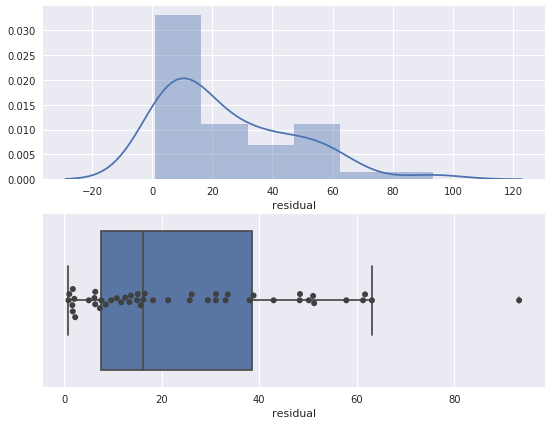

In [4]:
sns.set()
f, (ax1, ax2) = plt.subplots(nrows=2,figsize=(9,7))
sns.distplot(df_residual.residual, ax=ax1)
sns.boxplot(df_residual.residual, ax=ax2)
sns.swarmplot(df_residual.residual, ax=ax2, color=".25", size=6)

In [5]:
q1, q2 = 30, 50

visualization.choropleth_plot(
    data_polygon, 
    df_residual,
    df_dictionary,
    map_style='dark', # dark, satellite, streets, light, outdoors
    cmap_name='summer', # Blues, viridis, RdYlGn, autumn, summer
    none_data_rgba='rgba(0,0,0,0.15)', # rgba(0,0,0,0.15) rgba(255,255,255,1)
    opacity=1,
    is_reverse=False,
    is_category=True,
    q1=q1,
    q2=q2,
#     save_file=True,
#     filename='Nakhon-residual-dark-thresh.html'
)

In [7]:
df_residual_corr = residual.get_residual_corr(df_detect, df_population, df_area, df_residual, df_gsv_coverage, q1=q1, q2=q2)

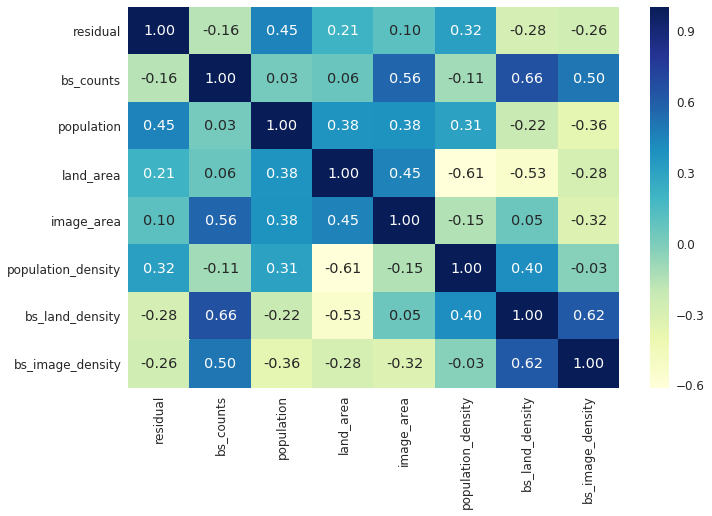

In [8]:
plt.figure(figsize=(11,7))
sns.set(font_scale=1.2)
sns.heatmap(df_residual_corr.corr(),  annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

'\nFit linear regression models to the scatter plots\n'

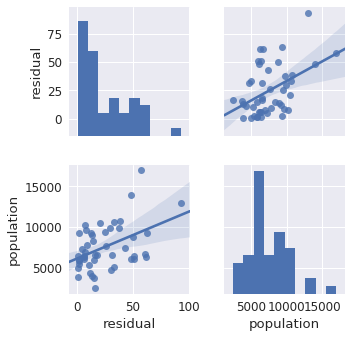

In [9]:
'''
Fit linear regression models to the scatter plots
'''
sns.set(font_scale=1.2)
sns.pairplot(df_residual_corr[['residual','population', 'category']], kind="reg")
plt.show()
